In [21]:
import cv2
import shapely
import subprocess
import numpy as np
import tifffile as tif
import matplotlib.pyplot as plt

from osgeo import gdal
from osgeo import ogr
from osgeo import osr
from osgeo import gdal_array
from osgeo import gdalconst

In [24]:
%matplotlib inline 

### Get the path to satellite image TIF and corresponding ShapeFile

In [7]:
def create_mask(img_path, shapefile_path, output_path):
    
    gdalformat = 'GTiff'
    datatype = gdal.GDT_Byte
    burnVal = 1 #value for the output image pixels
    ##########################################################
    
    # Get projection info from reference image
    Image = gdal.Open(img_path, gdal.GA_ReadOnly)

    # Open Shapefile
    Shapefile = ogr.Open(shapefile_path)
    Shapefile_layer = Shapefile.GetLayer()

    # Rasterise
    print("Rasterising shapefile...")
    Output = gdal.GetDriverByName(gdalformat).Create(output_path, Image.RasterXSize, Image.RasterYSize, 1, datatype, options=['COMPRESS=DEFLATE'])
    Output.SetProjection(Image.GetProjectionRef())
    Output.SetGeoTransform(Image.GetGeoTransform()) 

    # Write data to band 1
    Band = Output.GetRasterBand(1)
    Band.SetNoDataValue(0)
    gdal.RasterizeLayer(Output, [1], Shapefile_layer, burn_values=[burnVal])

    # Close datasets
    Band = None
    Output = None
    Image = None
    Shapefile = None

    # Build image overviews
    subprocess.call("gdaladdo --config COMPRESS_OVERVIEW DEFLATE "+output_path+" 2 4 8 16 32 64", shell=True)
    print("Done.")

The shapefile POLYGON.shp containing the boudning boxes of the identified objects are exported from the picterra platform

In [34]:
source = "/Users/paul/Desktop/picterra"
satellite_shapefile = source + "/polygons/madrid_airport_planes/POLYGON.shp"
satellite_image = "/Users/paul/Desktop/picterra/madrid_airport.TIF"
output_result = source + "/object_detection_result/madrid_airport_planes_mask.TIF"

In [35]:
create_mask(satellite_image, satellite_shapefile, output_result)

Rasterising shapefile...
Done.


### Superimpose mask and image

In [36]:
mask = tif.imread(output_result)
img = tif.imread(satellite_image)

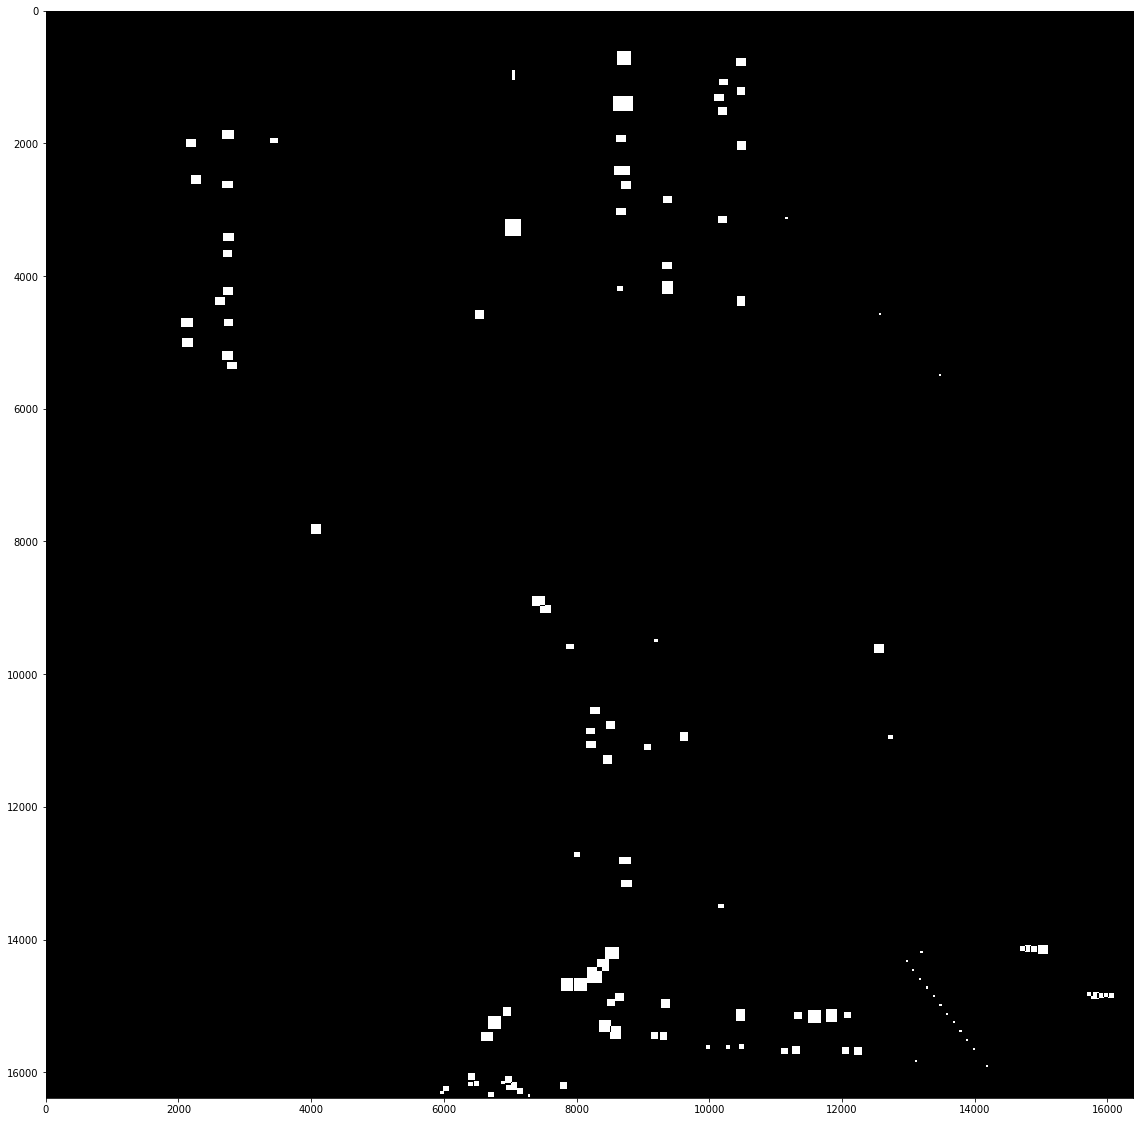

In [37]:
plt.figure(figsize=(20,20))
plt.imshow(tif.imread(output_result), cmap='gray')

In [27]:
def mask_color_img(img, mask, color=[0, 255, 255], alpha=0.3):
    '''
    img: cv2 image
    mask: bool or np.where
    color: BGR triplet [_, _, _]. Default: [0, 255, 255] is yellow.
    alpha: float [0, 1]. 

    Ref: http://www.pyimagesearch.com/2016/03/07/transparent-overlays-with-opencv/
    '''
    img_copy = img.copy()
    x,y = np.where(mask[:,:,0] == 1)
    img[x,y,:] = color
    out = cv2.addWeighted(img, alpha, img_copy, 1 - alpha, 0, img_copy)
    return(out)

In [38]:
img_reshaped = np.transpose(img, (1,2,0))
img_bgr = img_reshaped[...,[2,1,0]]
mask_bgr = mask[..., np.newaxis]

In [39]:
overlay = mask_color_img(img_bgr, mask_bgr)

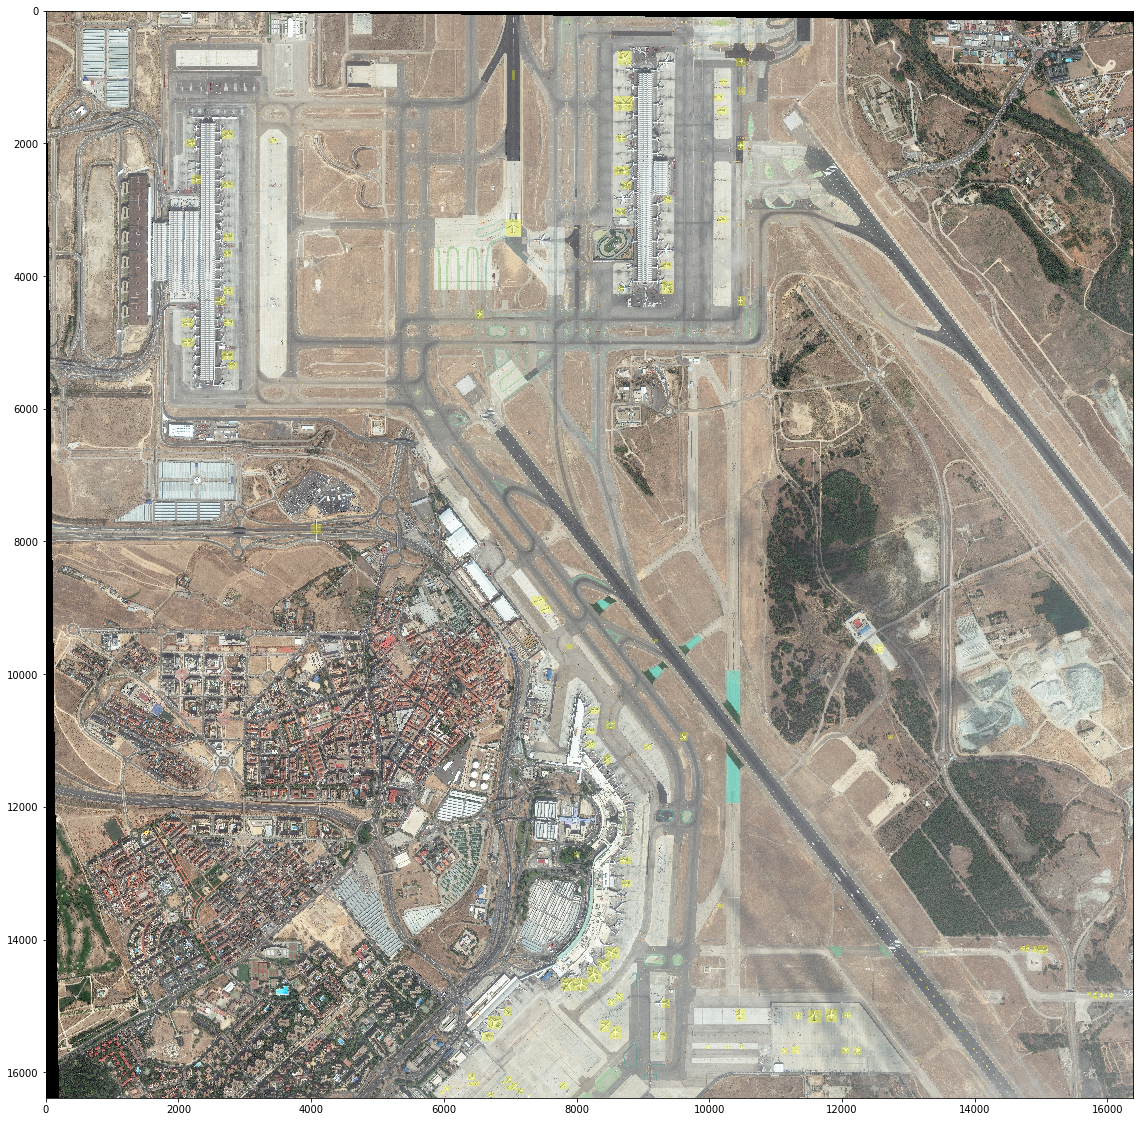

In [41]:
plt.figure(figsize=(20,20))
plt.imshow(overlay[...,[2,1,0]])

In [42]:
%%time
cv2.imwrite('./object_detection_result/overlay_madrid_planes.png', overlay)

CPU times: user 13.4 s, sys: 1.16 s, total: 14.6 s
Wall time: 15.3 s


True